In [1]:
# plot histograms of chlorophyll anomalies
# Fig. 4 in paper (absolute storm-induced anomalies)
# Fig. 5 in paper (relative to derivations from cliamtology only)

In [2]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, MFDataset
import numba as nb
import time as timing
from numba import njit 
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
import seawater as sw
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [3]:
#---
# CHOOSE YEARS to plot
#---

years = np.arange(1997,2018+1,1) 

#---
# SAVEPATH
#---

#---
# where to save plots?
#---
savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/'+\
                    'storm_anomalies_vs_deviations_from_clim/FIXED_DUPLICATES_v2/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
savepath2     = savepath+'eps/'
# check existence of paths
if not os.path.exists(savepath2):
    print ('Created '+savepath2)
    os.makedirs(savepath2)
    
dpicnt = 150
save_plots    = True
display_plots = True


In [4]:
#---
# FUNCTION 
#---

def get_distance_to_storm_center(lat2,lon2,aux_lat,aux_lon):
                
    # create list of locations within 1000km of the storm
    points_data = []
    for pp in range(0,lat2.shape[0]):
        aux = (lat2[pp],lon2[pp])
        points_data.append(aux)
        del aux

    #print(len(points_data))
    # for each of these points get the distance to the storm center in km -> get distance in x-dir and y-dir
    points_distance_x = np.zeros(len(points_data)) # distance in longitudinal direction, i.e., use latitude of storm (aux_lat)
    points_distance_y = np.zeros(len(points_data)) # distance in latitudinal direction, i.e., use longitude of storm (aux_lon)
    for pp in range(0,len(points_data)): 
        # distance in longitudinal direction
        aux_point = (aux_lat,points_data[pp][1])
        points_distance_x[pp] = distance(point_storm, aux_point).km
       # print(aux_point,point_storm,points_distance_x[pp])
        # check sign: if lon grid cell is smaller (=further west) than lon of storm, define distance to be negative
        if points_data[pp][1]<aux_lon:
            points_distance_x[pp] = -1*points_distance_x[pp]
        elif (aux_lon<0) & (points_data[pp][1]>0): # lon_storm is east of dateline, but grid cell is west of dateline (grid cell is also further west in this case!)
            if (points_data[pp][1]-360)<aux_lon:
                points_distance_x[pp] = -1*points_distance_x[pp]
        del aux_point
        # distance in latitudinal direction
        aux_point = (points_data[pp][0],aux_lon)
        points_distance_y[pp] = distance(point_storm, aux_point).km
        # check sign: if lat grid cell is smaller (=further south) than lat of storm, define distance to be negative
        if points_data[pp][0]<aux_lat:
            points_distance_y[pp] = -1*points_distance_y[pp]
        del aux_point  
    return points_distance_x,points_distance_y,points_data
                    
    
def bin_points_as_distance_to_storm_center(counter,points_distance_x,points_distance_y,x_bins,y_bins,aux_data_anom,data_storm_mean,data_storm_std,data_storm_count):
    # data_storm_mean,data_storm_std,data_storm_count: initialized arrays, will be filled in this function and then returned
    
    # bin the points (account for where each point is relative to storm center)
    ind_x = np.digitize(points_distance_x,x_bins,right=False) # minimum is 1 (not zero!!)
    ind_y = np.digitize(points_distance_y,y_bins,right=False)
 #   print(np.min(ind_x),np.max(ind_x))
 #   print(np.min(ind_y),np.max(ind_y))
    # returned index satisfies: bins[i-1] <= x < bins[i]

   # print(aux_data_anom.shape)
    for xx in range(1,len(x_bins)+1): # start at 1 here -> see note above for ind_x
        for yy in range(1,len(x_bins)+1):
            index = np.where((ind_y==yy) & (ind_x==xx))[0]
            if len(index)>0:
                #if counter==6: 
                #    print(xx,yy,index.shape,aux_data_anom.shape)
                #if (counter==40) & (xx==11) & (yy==20):
                #    print(xx,yy,len(points_distance_x))
                #    print(index)
                #    print(index.shape,aux_data_anom.shape)
                # anomaly 2
                data_storm_mean[xx-1,yy-1]  = np.nanmean(aux_data_anom[index])
                data_storm_std[xx-1,yy-1]   = np.nanstd(aux_data_anom[index])
                data_storm_count[xx-1,yy-1] = index.shape[0]
            del index
    return data_storm_mean,data_storm_std,data_storm_count
    

In [5]:
#---
# LOAD COMPOSITES for totChl (low res/full, low res/emulator, high res)
#---

def get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,ratio_median,ratio_median_monthly):
    
    # get the median ratio for each year
    counter = 0
    for ss in range(0,data_storm_aux.shape[0]):
        aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
        if not np.isnan(aux_field):
            ratio_median[yy] = ratio_median[yy] + aux_field
            counter = counter+1
    ratio_median[yy] = np.divide(ratio_median[yy],counter)
    
    # get the median ratio for each year, EACH MONTH
    for mm in range(0,12):
        ind_mm = np.where(month_storm_aux==mm+1)[0]
        counter = 0
        for ss in ind_mm: 
            aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
            if not np.isnan(aux_field):
                ratio_median_monthly[yy,mm] = ratio_median_monthly[yy,mm] + aux_field
                counter = counter+1
        ratio_median_monthly[yy,mm] = np.divide(ratio_median_monthly[yy,mm],counter)
        
    return ratio_median,ratio_median_monthly

def grow_arrays(yy,year_list,data_storm_aux,data_dev_aux,month_storm_aux,lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux,\
                                                           data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm): 
    if yy==0:
        data_storm  = data_storm_aux
        data_dev    = data_dev_aux
        month_storm = month_storm_aux
        lat_storm   = lat_storm_aux
        lon_storm   = lon_storm_aux
        slp_min_storm   = slp_min_storm_aux
        slp_avg_storm   = slp_avg_storm_aux
        year_storm = year_list[yy]*np.ones(data_storm_aux.shape[0])
    else:
        data_storm  = np.concatenate((data_storm,data_storm_aux))
        data_dev    = np.concatenate((data_dev,data_dev_aux))
        month_storm = np.concatenate((month_storm,month_storm_aux))
        lat_storm   = np.concatenate((lat_storm,lat_storm_aux))
        lon_storm   = np.concatenate((lon_storm,lon_storm_aux))
        slp_min_storm   = np.concatenate((slp_min_storm,slp_min_storm_aux))
        slp_avg_storm   = np.concatenate((slp_avg_storm,slp_avg_storm_aux))
        year_storm  = np.concatenate((year_storm,year_list[yy]*np.ones(data_storm_aux.shape[0])))
                
    return data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm

def load_data(path1a,path1b,file1,file3,vari1a,vari1b): 
    # storm-induced anomaly
    ff  = xr.open_dataset(path1a+file1)
    data_storm_aux  = ff[vari1a+'_storm_anomaly4_mean'].values 
    month_storm_aux = ff['month_storm'].values  # at min. SLP
    day_storm_aux   = ff['day_storm'].values  # at min. SLP
    year_storm_aux  = ff['year_storm'].values  # at min. SLP
    lat_storm_aux   = ff['lat_storm'].values  # at min. SLP
    lon_storm_aux   = ff['lon_storm'].values  # at min. SLP
    slp_avg_storm_aux   = ff['avg_min_slp_storm'].values  # avg of all min SLP over all time steps of the storm's existence 
    slp_min_storm_aux   = ff['min_min_slp_storm'].values  # min. SLP over all time steps of the storm's existence 
    ff.close()
    data_storm_aux[data_storm_aux==0] = np.nan
    
    # deviations from climatology
    ff  = xr.open_dataset(path1b+file3)
    data_dev_aux = ff[vari1b+'_storm_anomaly4_mean'].values 
    ff.close()
    data_dev_aux[data_dev_aux==0] = np.nan
    
    return data_storm_aux,day_storm_aux,month_storm_aux,year_storm_aux,\
                lat_storm_aux,lon_storm_aux,data_dev_aux,slp_avg_storm_aux,slp_min_storm_aux
    

year_list = np.arange(1997,2018+1,1)

vari = 'totChl'
path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'
path2 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_emulator_anomalies/'
path3 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_hr_anomalies/'
    
# what's the median ratio between storm-induced anomalies and deviations from clim?
ratio_median            = np.zeros([len(year_list)]) 
ratio_median_monthly    = np.zeros([len(year_list),12])
ratio_median_em         = np.zeros([len(year_list)]) 
ratio_median_monthly_em = np.zeros([len(year_list),12])
ratio_median_hr         = np.zeros([len(year_list)]) 
ratio_median_monthly_hr = np.zeros([len(year_list),12])
# initilize variables (will be overwritten!)
#data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm = [],[],[],[],[],[],[],[]
#data_storm_em,data_dev_em,month_storm_em,lat_storm_em,lon_storm_em,slp_avg_storm_em,slp_min_storm_em,year_storm_em = [],[],[],[],[],[],[],[]
#data_storm_hr,data_dev_hr,month_storm_hr,lat_storm_hr,lon_storm_hr,slp_avg_storm_hr,slp_min_storm_hr,year_storm_hr = [],[],[],[],[],[],[],[]

#----
# LOW RES, FULL FIELD
#----
    
# storm-induced anomaly
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'

# load data
data_storm,day_storm,month_storm,year_storm,lat_storm,lon_storm,\
            data_dev,slp_avg_storm,slp_min_storm = load_data(path1,path1,file1,file3,vari,vari)
    
## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
#ratio_median,ratio_median_monthly = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
#                                                         ratio_median,ratio_median_monthly)
        
#----
# LOW RES, EMULATOR
#----
    
# storm-induced anomaly
#file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
#            str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
            str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc' # in TEST folder, this is the file using the full-field clim
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc' # uses full-field clim

# storm-induced anomaly


# load data
data_storm_em,day_storm_em,month_storm_em,year_storm_em,lat_storm_em,lon_storm_em,\
            data_dev_em,slp_avg_storm_em,slp_min_storm_em = load_data(path2+'TEST/',path1,file1,file3,vari+'_emulator',vari)
    
    
plot_hr = True
if plot_hr:
    #----
    # HIGH RES, FULL FIELD
    #----

    # storm-induced anomaly
    file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
    # deviations from climatology
    file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'

    # load data
    data_storm_hr,day_storm_hr,month_storm_hr,year_storm_hr,lat_storm_hr,lon_storm_hr,\
                data_dev_hr,slp_avg_storm_hr,slp_min_storm_hr = load_data(path3,path3,file1,file3,vari,vari)

    ## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
    #ratio_median_hr,ratio_median_monthly_hr = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
    #                                                     ratio_median_hr,ratio_median_monthly_hr)

    print(data_storm_hr.shape,data_dev_hr.shape)
    
print(data_storm.shape,data_dev.shape)
print(data_storm_em.shape,data_dev_em.shape)



#----
# make sure that the same storms are considered in LOW RES and HIGH RES
#----

data_aux_mean = np.nanmean(np.nanmean(data_storm,axis=2),axis=1)
ind_no_NaN = np.where(~np.isnan(data_aux_mean))[0]
ind_no_NaN_lr = np.copy(ind_no_NaN) # for wind speeds further down

data_storm     = data_storm[ind_no_NaN,:,:]
data_storm_em  = data_storm_em[ind_no_NaN,:,:]
if plot_hr:
    data_storm_hr  = data_storm_hr[ind_no_NaN,:,:]
data_dev     = data_dev[ind_no_NaN,:,:]
data_dev_em  = data_dev_em[ind_no_NaN,:,:]
if plot_hr:
    data_dev_hr  = data_dev_hr[ind_no_NaN,:,:]

month_storm = month_storm[ind_no_NaN]
year_storm  = year_storm[ind_no_NaN]
lat_storm   = lat_storm[ind_no_NaN]
lon_storm   = lon_storm[ind_no_NaN]
slp_avg_storm = slp_avg_storm[ind_no_NaN]
slp_min_storm = slp_min_storm[ind_no_NaN]

if plot_hr:
    month_storm_hr = month_storm_hr[ind_no_NaN]
    year_storm_hr  = year_storm_hr[ind_no_NaN]
    lat_storm_hr   = lat_storm_hr[ind_no_NaN]
    lon_storm_hr   = lon_storm_hr[ind_no_NaN]
    slp_avg_storm_hr = slp_avg_storm_hr[ind_no_NaN]
    slp_min_storm_hr = slp_min_storm_hr[ind_no_NaN]

month_storm_em = month_storm_em[ind_no_NaN]
year_storm_em  = year_storm_em[ind_no_NaN]
lat_storm_em   = lat_storm_em[ind_no_NaN]
lon_storm_em   = lon_storm_em[ind_no_NaN]
slp_avg_storm_em = slp_avg_storm_em[ind_no_NaN]
slp_min_storm_em = slp_min_storm_em[ind_no_NaN]

print('data_storm_em.shape',data_storm_em.shape)
if plot_hr:
    print('data_storm_hr.shape',data_storm_hr.shape)
print('data_storm.shape',data_storm.shape)


(9615, 21, 21) (9615, 21, 21)
(9615, 21, 21) (9615, 21, 21)
(9615, 21, 21) (9615, 21, 21)
data_storm_em.shape (9554, 21, 21)
data_storm_hr.shape (9554, 21, 21)
data_storm.shape (9554, 21, 21)


/tmp/ipykernel_2294853/3236905475.py:167: RuntimeWarning: Mean of empty slice
  data_aux_mean = np.nanmean(np.nanmean(data_storm,axis=2),axis=1)


/tmp/ipykernel_2294853/1034891763.py:27: RuntimeWarning: Mean of empty slice
  ratio_em[tt] = 100*np.nanmean(data_storm_em[tt,:,:])/np.nanmean(data_dev_em[tt,:,:])


Number of storms: 9554
Number without NaNs (low res, full): 9554
Number without NaNs (low res, emulator): 7833
Number without NaNs (high res, full): 9554

low res, full...
-109.79586337592757
-30.24627225410002
9.201688698611777
45.65405968000092
125.02693218252442


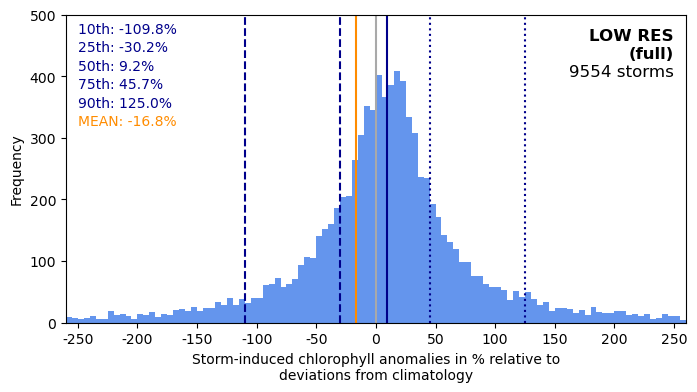

low res, emulator...
-215.85074378880495
-54.625428459504455
6.216696043889759
73.06816590927052
241.60864812225316


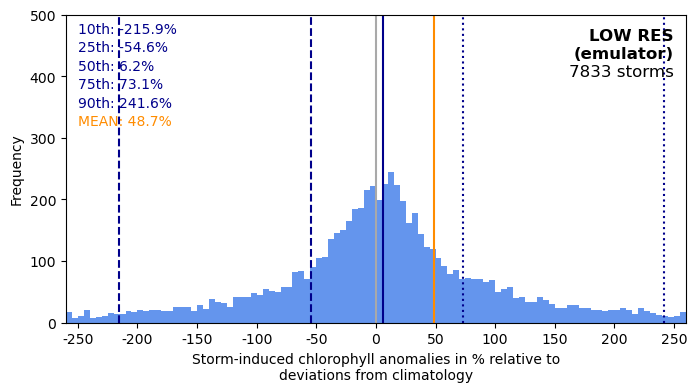

high res, full...
-93.56369101517326
-26.78618885408902
5.07863267208687
39.79034388520711
109.25430971799342


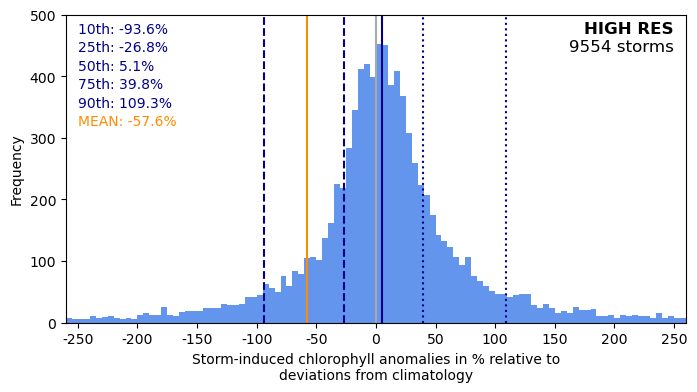

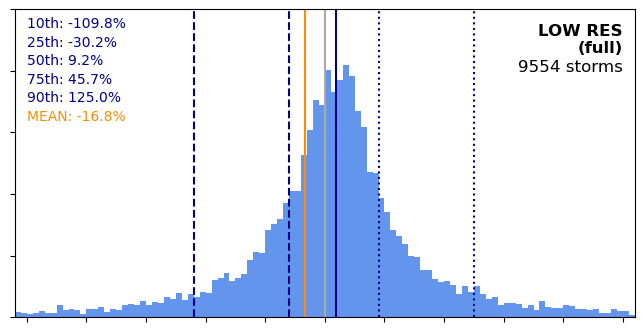

low res, emulator...
-215.85074378880495
-54.625428459504455
6.216696043889759
73.06816590927052
241.60864812225316


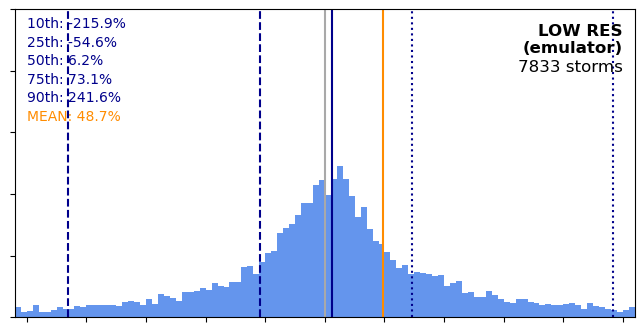

high res, full...
-93.56369101517326
-26.78618885408902
5.07863267208687
39.79034388520711
109.25430971799342


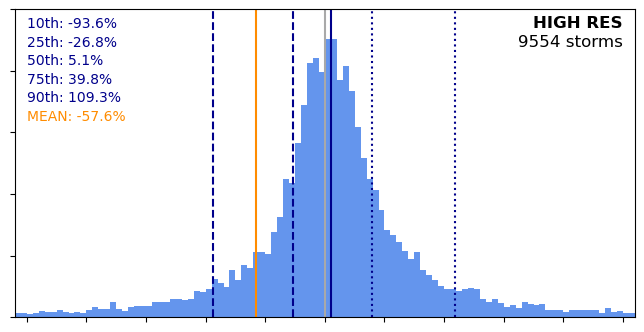

In [6]:
#----
# histogram over all storms: how does the storm-induced anomaly compare to deviations from the climatology? 
#----
#
# later: 
#   do this for each month (show median +- percentiles)
#   do this for emulator & HR
#   do this for different regions (use each time step of each storm)
#   are histograms the best way to show this?
#
# for both the temporal analysis and the latitudinal analysis:
#    decide if I want to take the month/lat at the time of min SLP or those at each time step of the storm
#     -> save composites for each time step individually! (LR, HR, emulator)
#     -> 1) plot average composite for each storm using month/location of min SLP
#     -> 2) plot composite for each storm at min. SLP ONLY using month/location of min SLP
#     -> 3) plot composite of each time step of each storm using month/location at each time step!
#

num_storms = data_storm.shape[0]

ratio    = np.zeros([num_storms])
if plot_hr:
    ratio_hr = np.zeros([num_storms])
ratio_em = np.zeros([num_storms])
for tt in range(0,num_storms):
    ratio[tt]    = 100*np.nanmean(data_storm[tt,:,:])/np.nanmean(data_dev[tt,:,:])
    ratio_em[tt] = 100*np.nanmean(data_storm_em[tt,:,:])/np.nanmean(data_dev_em[tt,:,:])
    if plot_hr:
        ratio_hr[tt] = 100*np.nanmean(data_storm_hr[tt,:,:])/np.nanmean(data_dev_hr[tt,:,:])
    
ind_no_NaN    = np.where(~np.isnan(ratio))[0]
ind_no_NaN_em = np.where(~np.isnan(ratio_em))[0]
if plot_hr:
    ind_no_NaN_hr = np.where(~np.isnan(ratio_hr))[0]
print('Number of storms:',num_storms)
print('Number without NaNs (low res, full):',ind_no_NaN.shape[0])
print('Number without NaNs (low res, emulator):',ind_no_NaN_em.shape[0])
if plot_hr:
    print('Number without NaNs (high res, full):',ind_no_NaN_hr.shape[0])
print()

bins = np.arange(-260,260+5,5)

xticks = [-250,-200,-150,-100,-50,0,50,100,150,200,250]
xticklabels = [-250,-200,-150,-100,-50,0,50,100,150,200,250]
yticks = [0,100,200,300,400,500]
yticklabels = [0,100,200,300,400,500]


color1 = 'cornflowerblue'
color2 = 'darkblue'
color3 = 'darkgrey'
color4 = 'darkorange'
ylim1 = 500
fs = 10

hh,ww = 8,4 # 6,5

print('low res, full...')
print(np.percentile(ratio[ind_no_NaN],10))
print(np.percentile(ratio[ind_no_NaN],25))
print(np.percentile(ratio[ind_no_NaN],50))
print(np.percentile(ratio[ind_no_NaN],75))
print(np.percentile(ratio[ind_no_NaN],90))
fig = plt.figure(figsize=(hh,ww))
plt.vlines(0,0,ylim1,color=color3)
plt.vlines(np.percentile(ratio[ind_no_NaN],10),0,ylim1,color=color2,linestyle='--')
plt.vlines(np.percentile(ratio[ind_no_NaN],25),0,ylim1,color=color2,linestyle='--')
plt.vlines(np.percentile(ratio[ind_no_NaN],50),0,ylim1,color=color2,linestyle='-')
plt.vlines(np.percentile(ratio[ind_no_NaN],75),0,ylim1,color=color2,linestyle=':')
plt.vlines(np.percentile(ratio[ind_no_NaN],90),0,ylim1,color=color2,linestyle=':')
plt.vlines(np.mean(ratio[ind_no_NaN]),0,ylim1,color=color4,linestyle='-')
plt.hist(ratio,bins,color=color1)
plt.xlabel('Storm-induced chlorophyll anomalies in % relative to\ndeviations from climatology')
plt.ylabel('Frequency')
plt.ylim((0,ylim1))
plt.xlim((np.min(bins),np.max(bins)))
plt.xticks(xticks,xticklabels)
plt.yticks(yticks,yticklabels)
plt.annotate('LOW RES\n(full)',xy=(0.98,0.86),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
plt.annotate(str(ind_no_NaN.shape[0])+' storms',xy=(0.98,0.80),xycoords='axes fraction',fontsize=fs+2,ha='right') 
plt.annotate('10th: '+str(np.round(10*np.percentile(ratio[ind_no_NaN],10))/10)+'%',\
             xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('25th: '+str(np.round(10*np.percentile(ratio[ind_no_NaN],25))/10)+'%',\
             xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('50th: '+str(np.round(10*np.percentile(ratio[ind_no_NaN],50))/10)+'%',\
             xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('75th: '+str(np.round(10*np.percentile(ratio[ind_no_NaN],75))/10)+'%',\
             xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('90th: '+str(np.round(10*np.percentile(ratio[ind_no_NaN],90))/10)+'%',\
             xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('MEAN: '+str(np.round(10*np.mean(ratio[ind_no_NaN]))/10)+'%',\
             xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
if save_plots:
    filename = 'Histogram_all_storms_storm_anom_vs_deviations_from_clim_LOW_RES_full.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

print('low res, emulator...')
print(np.percentile(ratio_em[ind_no_NaN_em],10))
print(np.percentile(ratio_em[ind_no_NaN_em],25))
print(np.percentile(ratio_em[ind_no_NaN_em],50))
print(np.percentile(ratio_em[ind_no_NaN_em],75))
print(np.percentile(ratio_em[ind_no_NaN_em],90))
fig = plt.figure(figsize=(hh,ww))
plt.vlines(0,0,ylim1,color=color3)
plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],10),0,ylim1,color=color2,linestyle='--')
plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],25),0,ylim1,color=color2,linestyle='--')
plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],50),0,ylim1,color=color2,linestyle='-')
plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],75),0,ylim1,color=color2,linestyle=':')
plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],90),0,ylim1,color=color2,linestyle=':')
plt.vlines(np.mean(ratio_em[ind_no_NaN_em]),0,ylim1,color=color4,linestyle='-')
plt.hist(ratio_em,bins,color=color1)
plt.xlabel('Storm-induced chlorophyll anomalies in % relative to\ndeviations from climatology')
plt.ylabel('Frequency')
plt.ylim((0,ylim1))
plt.xlim((np.min(bins),np.max(bins)))
plt.xticks(xticks,xticklabels)
plt.yticks(yticks,yticklabels)
plt.annotate('LOW RES\n(emulator)',xy=(0.98,0.86),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
plt.annotate(str(ind_no_NaN_em.shape[0])+' storms',xy=(0.98,0.80),xycoords='axes fraction',fontsize=fs+2,ha='right') 
plt.annotate('10th: '+str(np.round(10*np.percentile(ratio_em[ind_no_NaN_em],10))/10)+'%',\
             xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('25th: '+str(np.round(10*np.percentile(ratio_em[ind_no_NaN_em],25))/10)+'%',\
             xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('50th: '+str(np.round(10*np.percentile(ratio_em[ind_no_NaN_em],50))/10)+'%',\
             xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('75th: '+str(np.round(10*np.percentile(ratio_em[ind_no_NaN_em],75))/10)+'%',\
             xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('90th: '+str(np.round(10*np.percentile(ratio_em[ind_no_NaN_em],90))/10)+'%',\
             xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('MEAN: '+str(np.round(10*np.mean(ratio_em[ind_no_NaN_em]))/10)+'%',\
             xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
if save_plots:
    filename = 'Histogram_all_storms_storm_anom_vs_deviations_from_clim_LOW_RES_emulator.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

if plot_hr:
    print('high res, full...')
    print(np.percentile(ratio_hr[ind_no_NaN_hr],10))
    print(np.percentile(ratio_hr[ind_no_NaN_hr],25))
    print(np.percentile(ratio_hr[ind_no_NaN_hr],50))
    print(np.percentile(ratio_hr[ind_no_NaN_hr],75))
    print(np.percentile(ratio_hr[ind_no_NaN_hr],90))
    fig = plt.figure(figsize=(hh,ww))
    plt.vlines(0,0,ylim1,color=color3)
    plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],10),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],25),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],50),0,ylim1,color=color2,linestyle='-')
    plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],75),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],90),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.mean(ratio_hr[ind_no_NaN_hr]),0,ylim1,color=color4,linestyle='-')
    plt.hist(ratio_hr,bins,color=color1)
    plt.xlabel('Storm-induced chlorophyll anomalies in % relative to\ndeviations from climatology')
    plt.ylabel('Frequency')
    plt.ylim((0,ylim1))
    plt.xlim((np.min(bins),np.max(bins)))
    plt.xticks(xticks,xticklabels)
    plt.yticks(yticks,yticklabels)
    plt.annotate('HIGH RES',xy=(0.98,0.94),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
    plt.annotate(str(ind_no_NaN_hr.shape[0])+' storms',xy=(0.98,0.88),xycoords='axes fraction',fontsize=fs+2,ha='right') 
    plt.annotate('10th: '+str(np.round(10*np.percentile(ratio_hr[ind_no_NaN_hr],10))/10)+'%',\
                 xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('25th: '+str(np.round(10*np.percentile(ratio_hr[ind_no_NaN_hr],25))/10)+'%',\
                 xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('50th: '+str(np.round(10*np.percentile(ratio_hr[ind_no_NaN_hr],50))/10)+'%',\
                 xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('75th: '+str(np.round(10*np.percentile(ratio_hr[ind_no_NaN_hr],75))/10)+'%',\
                 xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('90th: '+str(np.round(10*np.percentile(ratio_hr[ind_no_NaN_hr],90))/10)+'%',\
                 xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('MEAN: '+str(np.round(10*np.mean(ratio_hr[ind_no_NaN_hr]))/10)+'%',\
                 xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
    if save_plots:
        filename = 'Histogram_all_storms_storm_anom_vs_deviations_from_clim_HIGH_RES_full.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
    
plot_eps = True
if plot_eps:
    
    fig = plt.figure(figsize=(hh,ww))
    plt.vlines(0,0,ylim1,color=color3)
    plt.vlines(np.percentile(ratio[ind_no_NaN],10),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio[ind_no_NaN],25),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio[ind_no_NaN],50),0,ylim1,color=color2,linestyle='-')
    plt.vlines(np.percentile(ratio[ind_no_NaN],75),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.percentile(ratio[ind_no_NaN],90),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.mean(ratio[ind_no_NaN]),0,ylim1,color=color4,linestyle='-')
    plt.hist(ratio,bins,color=color1)
    plt.ylim((0,ylim1))
    plt.xlim((np.min(bins),np.max(bins)))
    plt.xticks(xticks,[])
    plt.yticks(yticks,[])
    plt.annotate('LOW RES\n(full)',xy=(0.98,0.86),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
    plt.annotate(str(ind_no_NaN.shape[0])+' storms',xy=(0.98,0.80),xycoords='axes fraction',fontsize=fs+2,ha='right') 
    plt.annotate('10th: '+str(np.round(10*np.percentile(ratio[ind_no_NaN],10))/10)+'%',\
                 xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('25th: '+str(np.round(10*np.percentile(ratio[ind_no_NaN],25))/10)+'%',\
                 xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('50th: '+str(np.round(10*np.percentile(ratio[ind_no_NaN],50))/10)+'%',\
                 xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('75th: '+str(np.round(10*np.percentile(ratio[ind_no_NaN],75))/10)+'%',\
                 xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('90th: '+str(np.round(10*np.percentile(ratio[ind_no_NaN],90))/10)+'%',\
                 xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('MEAN: '+str(np.round(10*np.mean(ratio[ind_no_NaN]))/10)+'%',\
                 xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
    if save_plots:
        filename = 'Histogram_all_storms_storm_anom_vs_deviations_from_clim_LOW_RES_full.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    print('low res, emulator...')
    print(np.percentile(ratio_em[ind_no_NaN_em],10))
    print(np.percentile(ratio_em[ind_no_NaN_em],25))
    print(np.percentile(ratio_em[ind_no_NaN_em],50))
    print(np.percentile(ratio_em[ind_no_NaN_em],75))
    print(np.percentile(ratio_em[ind_no_NaN_em],90))
    fig = plt.figure(figsize=(hh,ww))
    plt.vlines(0,0,ylim1,color=color3)
    plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],10),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],25),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],50),0,ylim1,color=color2,linestyle='-')
    plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],75),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],90),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.mean(ratio_em[ind_no_NaN_em]),0,ylim1,color=color4,linestyle='-')
    plt.hist(ratio_em,bins,color=color1)
    plt.ylim((0,ylim1))
    plt.xlim((np.min(bins),np.max(bins)))
    plt.xticks(xticks,[])
    plt.yticks(yticks,[])
    plt.annotate('LOW RES\n(emulator)',xy=(0.98,0.86),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
    plt.annotate(str(ind_no_NaN_em.shape[0])+' storms',xy=(0.98,0.80),xycoords='axes fraction',fontsize=fs+2,ha='right') 
    plt.annotate('10th: '+str(np.round(10*np.percentile(ratio_em[ind_no_NaN_em],10))/10)+'%',\
                 xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('25th: '+str(np.round(10*np.percentile(ratio_em[ind_no_NaN_em],25))/10)+'%',\
                 xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('50th: '+str(np.round(10*np.percentile(ratio_em[ind_no_NaN_em],50))/10)+'%',\
                 xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('75th: '+str(np.round(10*np.percentile(ratio_em[ind_no_NaN_em],75))/10)+'%',\
                 xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('90th: '+str(np.round(10*np.percentile(ratio_em[ind_no_NaN_em],90))/10)+'%',\
                 xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('MEAN: '+str(np.round(10*np.mean(ratio_em[ind_no_NaN_em]))/10)+'%',\
                 xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
    if save_plots:
        filename = 'Histogram_all_storms_storm_anom_vs_deviations_from_clim_LOW_RES_emulator.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    if plot_hr:
        print('high res, full...')
        print(np.percentile(ratio_hr[ind_no_NaN_hr],10))
        print(np.percentile(ratio_hr[ind_no_NaN_hr],25))
        print(np.percentile(ratio_hr[ind_no_NaN_hr],50))
        print(np.percentile(ratio_hr[ind_no_NaN_hr],75))
        print(np.percentile(ratio_hr[ind_no_NaN_hr],90))
        fig = plt.figure(figsize=(hh,ww))
        plt.vlines(0,0,ylim1,color=color3)
        plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],10),0,ylim1,color=color2,linestyle='--')
        plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],25),0,ylim1,color=color2,linestyle='--')
        plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],50),0,ylim1,color=color2,linestyle='-')
        plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],75),0,ylim1,color=color2,linestyle=':')
        plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],90),0,ylim1,color=color2,linestyle=':')
        plt.vlines(np.mean(ratio_hr[ind_no_NaN_hr]),0,ylim1,color=color4,linestyle='-')
        plt.hist(ratio_hr,bins,color=color1)
        plt.ylim((0,ylim1))
        plt.xlim((np.min(bins),np.max(bins)))
        plt.xticks(xticks,[])
        plt.yticks(yticks,[])
        plt.annotate('HIGH RES',xy=(0.98,0.94),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
        plt.annotate(str(ind_no_NaN_hr.shape[0])+' storms',xy=(0.98,0.88),xycoords='axes fraction',fontsize=fs+2,ha='right') 
        plt.annotate('10th: '+str(np.round(10*np.percentile(ratio_hr[ind_no_NaN_hr],10))/10)+'%',\
                     xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        plt.annotate('25th: '+str(np.round(10*np.percentile(ratio_hr[ind_no_NaN_hr],25))/10)+'%',\
                     xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        plt.annotate('50th: '+str(np.round(10*np.percentile(ratio_hr[ind_no_NaN_hr],50))/10)+'%',\
                     xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        plt.annotate('75th: '+str(np.round(10*np.percentile(ratio_hr[ind_no_NaN_hr],75))/10)+'%',\
                     xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        plt.annotate('90th: '+str(np.round(10*np.percentile(ratio_hr[ind_no_NaN_hr],90))/10)+'%',\
                     xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        plt.annotate('MEAN: '+str(np.round(10*np.mean(ratio_hr[ind_no_NaN_hr]))/10)+'%',\
                     xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
        if save_plots:
            filename = 'Histogram_all_storms_storm_anom_vs_deviations_from_clim_HIGH_RES_full.eps'
            plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)


In [7]:
#---
# How many are above +/-50% ?
#---

print(ratio[ind_no_NaN].shape)
print(ratio_em[ind_no_NaN_em].shape)
if plot_hr:
    print(ratio_hr[ind_no_NaN_hr].shape)

ind1 = np.where(np.abs(ratio)>=50)[0]
ind2 = np.where(np.abs(ratio_em)>=50)[0]
if plot_hr:
    ind3 = np.where(np.abs(ratio_hr)>=50)[0]

print('LOW RES full field:',100*ind1.shape[0]/ratio[ind_no_NaN].shape[0])
print('LOW RES emulator:',100*ind2.shape[0]/ratio_em[ind_no_NaN].shape[0])
if plot_hr:
    print('HIGH RES full field:',100*ind3.shape[0]/ratio_hr[ind_no_NaN].shape[0])


(9554,)
(7833,)
(9554,)
LOW RES full field: 41.678877956876704
LOW RES emulator: 46.07494243248901
HIGH RES full field: 37.84802177098597


/tmp/ipykernel_2294853/1279010161.py:27: RuntimeWarning: Mean of empty slice
  ratio_em[tt] = np.nanmean(data_storm_em[tt,:,:])


Number without NaNs (low res, full): 9554
Number without NaNs (low res, emulator): 7833
Number without NaNs (high res, full): 9554

low res, full...
-0.031877598538994786
-0.0038157424423843622
-0.00013826429494656622
0.0027497612172737718
0.027502648532390647
MEAN -0.00011864026827557733


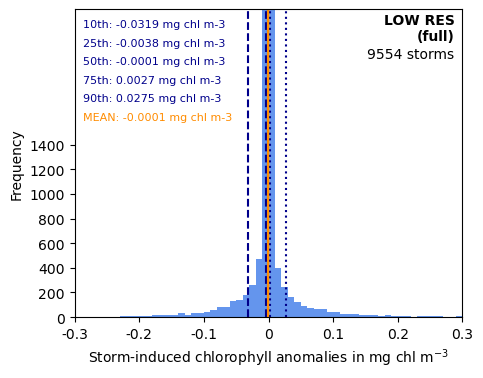

low res, emulator...
-0.052738986909389496
-0.009271904826164246
-0.00027766497805714607
0.007582715712487698
0.04559859409928322
MEAN -0.0007082741554456257


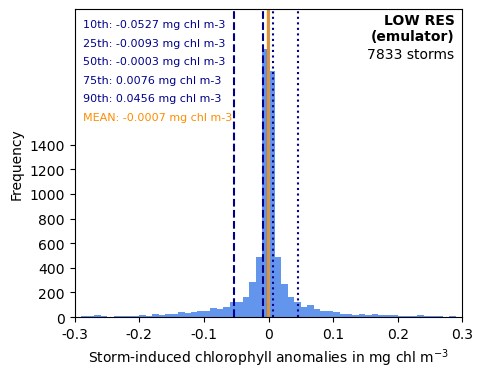

high res, full...
-0.04029571674764156
-0.006029541022144258
-0.00033935521787498146
0.0026015102048404515
0.02441586703062065
MEAN -0.002386061675511296


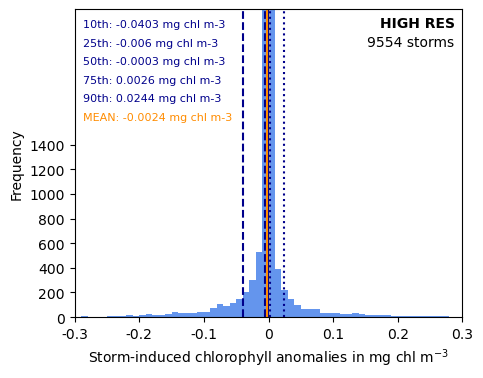

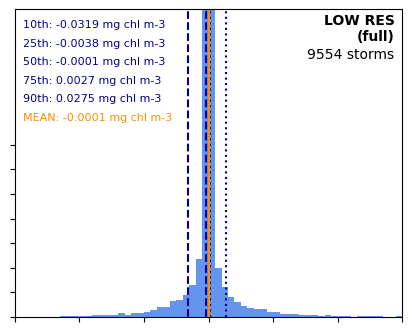

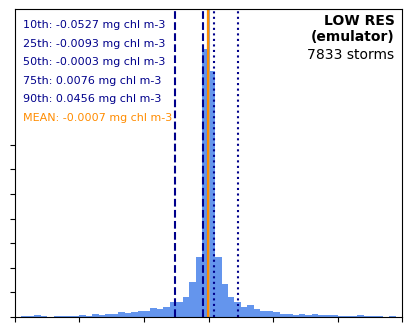

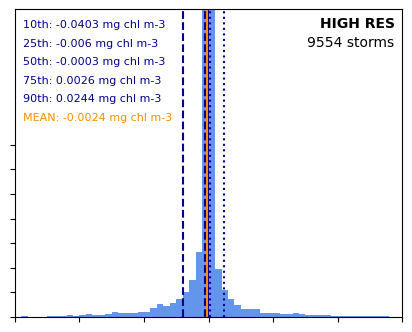

In [8]:
#----
# histogram over all storms: abs storm-induced chlorophyll anomalies
#----
#
# later: 
#   do this for each month (show median +- percentiles)
#   do this for emulator & HR
#   do this for different regions (use each time step of each storm)
#   are histograms the best way to show this?
#
# for both the temporal analysis and the latitudinal analysis:
#    decide if I want to take the month/lat at the time of min SLP or those at each time step of the storm
#     -> save composites for each time step individually! (LR, HR, emulator)
#     -> 1) plot average composite for each storm using month/location of min SLP
#     -> 2) plot composite for each storm at min. SLP ONLY using month/location of min SLP
#     -> 3) plot composite of each time step of each storm using month/location at each time step!
#

num_storms = data_storm.shape[0]

ratio    = np.zeros([num_storms])
if plot_hr:
    ratio_hr = np.zeros([num_storms])
ratio_em = np.zeros([num_storms])
for tt in range(0,num_storms):
    ratio[tt]    = np.nanmean(data_storm[tt,:,:])
    ratio_em[tt] = np.nanmean(data_storm_em[tt,:,:])
    if plot_hr:
        ratio_hr[tt] = np.nanmean(data_storm_hr[tt,:,:])

ind_no_NaN    = np.where(~np.isnan(ratio))[0]
ind_no_NaN_em = np.where(~np.isnan(ratio_em))[0]
if plot_hr:
    ind_no_NaN_hr = np.where(~np.isnan(ratio_hr))[0]
print('Number without NaNs (low res, full):',ind_no_NaN.shape[0])
print('Number without NaNs (low res, emulator):',ind_no_NaN_em.shape[0])
if plot_hr:
    print('Number without NaNs (high res, full):',ind_no_NaN_hr.shape[0])
print()

bins = np.arange(-0.3,0.3+0.01,0.01)
color1 = 'cornflowerblue'
color2 = 'darkblue'
color3 = 'darkgrey'
color4 = 'darkorange'
ylim1 = 2500
fs = 8
factor = 10000

ww,hh = 5,4

print('low res, full...')
print(np.percentile(ratio[ind_no_NaN],10))
print(np.percentile(ratio[ind_no_NaN],25))
print(np.percentile(ratio[ind_no_NaN],50))
print(np.percentile(ratio[ind_no_NaN],75))
print(np.percentile(ratio[ind_no_NaN],90))
print('MEAN',np.mean(ratio[ind_no_NaN]))
fig = plt.figure(figsize=(ww,hh))
plt.vlines(0,0,ylim1,color=color3)
plt.vlines(np.percentile(ratio[ind_no_NaN],10),0,ylim1,color=color2,linestyle='--')
plt.vlines(np.percentile(ratio[ind_no_NaN],25),0,ylim1,color=color2,linestyle='--')
plt.vlines(np.percentile(ratio[ind_no_NaN],50),0,ylim1,color=color2,linestyle='-')
plt.vlines(np.percentile(ratio[ind_no_NaN],75),0,ylim1,color=color2,linestyle=':')
plt.vlines(np.percentile(ratio[ind_no_NaN],90),0,ylim1,color=color2,linestyle=':')
plt.vlines(np.mean(ratio[ind_no_NaN]),0,ylim1,color=color4,linestyle='-')
plt.hist(ratio,bins,color=color1)
plt.xlabel('Storm-induced chlorophyll anomalies in mg chl m$^{-3}$')
plt.ylabel('Frequency')
plt.ylim((0,ylim1))
plt.xlim((np.min(bins),np.max(bins)))
plt.xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3],[-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
plt.yticks([0,200,400,600,800,1000,1200,1400],[0,200,400,600,800,1000,1200,1400])
plt.annotate('LOW RES\n(full)',xy=(0.98,0.90),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
plt.annotate(str(ind_no_NaN.shape[0])+' storms',xy=(0.98,0.84),xycoords='axes fraction',fontsize=fs+2,ha='right') 
plt.annotate('10th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],10))/factor)+' mg chl m-3',\
             xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('25th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],25))/factor)+' mg chl m-3',\
             xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('50th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],50))/factor)+' mg chl m-3',\
             xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('75th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],75))/factor)+' mg chl m-3',\
             xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('90th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],90))/factor)+' mg chl m-3',\
             xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('MEAN: '+str(np.round(factor*np.mean(ratio[ind_no_NaN]))/factor)+' mg chl m-3',\
             xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
if save_plots:
    filename = 'Histogram_all_storms_storm_anom_from_clim_LOW_RES_full.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

print('low res, emulator...')
print(np.percentile(ratio_em[ind_no_NaN_em],10))
print(np.percentile(ratio_em[ind_no_NaN_em],25))
print(np.percentile(ratio_em[ind_no_NaN_em],50))
print(np.percentile(ratio_em[ind_no_NaN_em],75))
print(np.percentile(ratio_em[ind_no_NaN_em],90))
print('MEAN',np.mean(ratio_em[ind_no_NaN_em]))
fig = plt.figure(figsize=(ww,hh))
plt.vlines(0,0,ylim1,color=color3)
plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],10),0,ylim1,color=color2,linestyle='--')
plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],25),0,ylim1,color=color2,linestyle='--')
plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],50),0,ylim1,color=color2,linestyle='-')
plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],75),0,ylim1,color=color2,linestyle=':')
plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],90),0,ylim1,color=color2,linestyle=':')
plt.vlines(np.mean(ratio_em[ind_no_NaN_em]),0,ylim1,color=color4,linestyle='-')
plt.hist(ratio_em,bins,color=color1)
plt.xlabel('Storm-induced chlorophyll anomalies in mg chl m$^{-3}$')
plt.ylabel('Frequency')
plt.ylim((0,ylim1))
plt.xlim((np.min(bins),np.max(bins)))
plt.xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3],[-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
plt.yticks([0,200,400,600,800,1000,1200,1400],[0,200,400,600,800,1000,1200,1400])
plt.annotate('LOW RES\n(emulator)',xy=(0.98,0.90),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
plt.annotate(str(ind_no_NaN_em.shape[0])+' storms',xy=(0.98,0.84),xycoords='axes fraction',fontsize=fs+2,ha='right') 
plt.annotate('10th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],10))/factor)+' mg chl m-3',\
             xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('25th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],25))/factor)+' mg chl m-3',\
             xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('50th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],50))/factor)+' mg chl m-3',\
             xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('75th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],75))/factor)+' mg chl m-3',\
             xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('90th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],90))/factor)+' mg chl m-3',\
             xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
plt.annotate('MEAN: '+str(np.round(factor*np.mean(ratio_em[ind_no_NaN_em]))/factor)+' mg chl m-3',\
             xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
if save_plots:
    filename = 'Histogram_all_storms_storm_anom_from_clim_LOW_RES_emulator.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

if plot_hr:
    print('high res, full...')
    print(np.percentile(ratio_hr[ind_no_NaN_hr],10))
    print(np.percentile(ratio_hr[ind_no_NaN_hr],25))
    print(np.percentile(ratio_hr[ind_no_NaN_hr],50))
    print(np.percentile(ratio_hr[ind_no_NaN_hr],75))
    print(np.percentile(ratio_hr[ind_no_NaN_hr],90))
    print('MEAN',np.mean(ratio_hr[ind_no_NaN_hr]))
    fig = plt.figure(figsize=(ww,hh))
    plt.vlines(0,0,ylim1,color=color3)
    plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],10),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],25),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],50),0,ylim1,color=color2,linestyle='-')
    plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],75),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],90),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.mean(ratio_hr[ind_no_NaN_hr]),0,ylim1,color=color4,linestyle='-')
    plt.hist(ratio_hr,bins,color=color1)
    plt.xlabel('Storm-induced chlorophyll anomalies in mg chl m$^{-3}$')
    plt.ylabel('Frequency')
    plt.ylim((0,ylim1))
    plt.xlim((np.min(bins),np.max(bins)))
    plt.xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3],[-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
    plt.yticks([0,200,400,600,800,1000,1200,1400],[0,200,400,600,800,1000,1200,1400])
    plt.annotate('HIGH RES',xy=(0.98,0.94),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
    plt.annotate(str(ind_no_NaN_hr.shape[0])+' storms',xy=(0.98,0.88),xycoords='axes fraction',fontsize=fs+2,ha='right') 
    plt.annotate('10th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],10))/factor)+' mg chl m-3',\
                 xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('25th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],25))/factor)+' mg chl m-3',\
                 xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('50th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],50))/factor)+' mg chl m-3',\
                 xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('75th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],75))/factor)+' mg chl m-3',\
                 xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('90th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],90))/factor)+' mg chl m-3',\
                 xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('MEAN: '+str(np.round(factor*np.mean(ratio_hr[ind_no_NaN_hr]))/factor)+' mg chl m-3',\
                 xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
    if save_plots:
        filename = 'Histogram_all_storms_storm_anom_from_clim_HIGH_RES_full.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
    
    
plot_eps = True
if plot_eps:
    fig = plt.figure(figsize=(ww,hh))
    plt.vlines(0,0,ylim1,color=color3)
    plt.vlines(np.percentile(ratio[ind_no_NaN],10),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio[ind_no_NaN],25),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio[ind_no_NaN],50),0,ylim1,color=color2,linestyle='-')
    plt.vlines(np.percentile(ratio[ind_no_NaN],75),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.percentile(ratio[ind_no_NaN],90),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.mean(ratio[ind_no_NaN]),0,ylim1,color=color4,linestyle='-')
    plt.hist(ratio,bins,color=color1)
    plt.ylim((0,ylim1))
    plt.xlim((np.min(bins),np.max(bins)))
    plt.xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3],[])
    plt.yticks([0,200,400,600,800,1000,1200,1400],[])
    plt.annotate('LOW RES\n(full)',xy=(0.98,0.90),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
    plt.annotate(str(ind_no_NaN.shape[0])+' storms',xy=(0.98,0.84),xycoords='axes fraction',fontsize=fs+2,ha='right') 
    plt.annotate('10th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],10))/factor)+' mg chl m-3',\
                 xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('25th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],25))/factor)+' mg chl m-3',\
                 xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('50th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],50))/factor)+' mg chl m-3',\
                 xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('75th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],75))/factor)+' mg chl m-3',\
                 xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('90th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],90))/factor)+' mg chl m-3',\
                 xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('MEAN: '+str(np.round(factor*np.mean(ratio[ind_no_NaN]))/factor)+' mg chl m-3',\
                 xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
    if save_plots:
        filename = 'Histogram_all_storms_storm_anom_from_clim_LOW_RES_full.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
        
    fig = plt.figure(figsize=(ww,hh))
    plt.vlines(0,0,ylim1,color=color3)
    plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],10),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],25),0,ylim1,color=color2,linestyle='--')
    plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],50),0,ylim1,color=color2,linestyle='-')
    plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],75),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.percentile(ratio_em[ind_no_NaN_em],90),0,ylim1,color=color2,linestyle=':')
    plt.vlines(np.mean(ratio_em[ind_no_NaN_em]),0,ylim1,color=color4,linestyle='-')
    plt.hist(ratio_em,bins,color=color1)
    plt.ylim((0,ylim1))
    plt.xlim((np.min(bins),np.max(bins)))
    plt.xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3],[])
    plt.yticks([0,200,400,600,800,1000,1200,1400],[])
    plt.annotate('LOW RES\n(emulator)',xy=(0.98,0.90),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
    plt.annotate(str(ind_no_NaN_em.shape[0])+' storms',xy=(0.98,0.84),xycoords='axes fraction',fontsize=fs+2,ha='right') 
    plt.annotate('10th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],10))/factor)+' mg chl m-3',\
                 xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('25th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],25))/factor)+' mg chl m-3',\
                 xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('50th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],50))/factor)+' mg chl m-3',\
                 xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('75th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],75))/factor)+' mg chl m-3',\
                 xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('90th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],90))/factor)+' mg chl m-3',\
                 xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    plt.annotate('MEAN: '+str(np.round(factor*np.mean(ratio_em[ind_no_NaN_em]))/factor)+' mg chl m-3',\
                 xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
    if save_plots:
        filename = 'Histogram_all_storms_storm_anom_from_clim_LOW_RES_emulator.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    if plot_hr:
        fig = plt.figure(figsize=(ww,hh))
        plt.vlines(0,0,ylim1,color=color3)
        plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],10),0,ylim1,color=color2,linestyle='--')
        plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],25),0,ylim1,color=color2,linestyle='--')
        plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],50),0,ylim1,color=color2,linestyle='-')
        plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],75),0,ylim1,color=color2,linestyle=':')
        plt.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],90),0,ylim1,color=color2,linestyle=':')
        plt.vlines(np.mean(ratio_hr[ind_no_NaN_hr]),0,ylim1,color=color4,linestyle='-')
        plt.hist(ratio_hr,bins,color=color1)
        plt.ylim((0,ylim1))
        plt.xlim((np.min(bins),np.max(bins)))
        plt.xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3],[])
        plt.yticks([0,200,400,600,800,1000,1200,1400],[])
        plt.annotate('HIGH RES',xy=(0.98,0.94),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
        plt.annotate(str(ind_no_NaN_hr.shape[0])+' storms',xy=(0.98,0.88),xycoords='axes fraction',fontsize=fs+2,ha='right') 
        plt.annotate('10th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],10))/factor)+' mg chl m-3',\
                     xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        plt.annotate('25th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],25))/factor)+' mg chl m-3',\
                     xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        plt.annotate('50th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],50))/factor)+' mg chl m-3',\
                     xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        plt.annotate('75th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],75))/factor)+' mg chl m-3',\
                     xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        plt.annotate('90th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],90))/factor)+' mg chl m-3',\
                     xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        plt.annotate('MEAN: '+str(np.round(factor*np.mean(ratio_hr[ind_no_NaN_hr]))/factor)+' mg chl m-3',\
                     xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')
        if save_plots:
            filename = 'Histogram_all_storms_storm_anom_from_clim_HIGH_RES_full.eps'
            plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)

    

In [9]:
print(data_storm.shape)

# the numbers below do not match the numbers printed in the figures above (order of averaging has changed)
# which is the one I should use?
factor = 10000
print('LOW RES full field:',np.round(factor*np.nanmean(data_storm))/factor)
print('LOW RES emulator:',np.round(factor*np.nanmean(data_storm_em))/factor)
if plot_hr:
    print('HIGH RES full field:',np.round(factor*np.nanmean(data_storm_hr))/factor)


(9554, 21, 21)
LOW RES full field: 0.0008
LOW RES emulator: -0.0002
HIGH RES full field: -0.0017


low res, full...


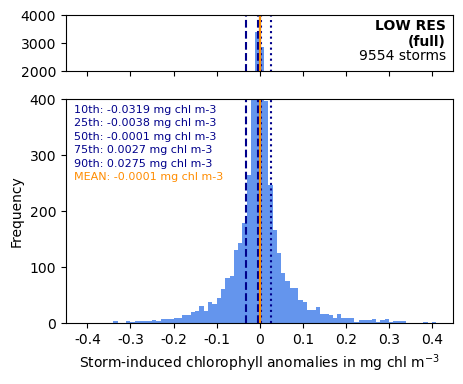

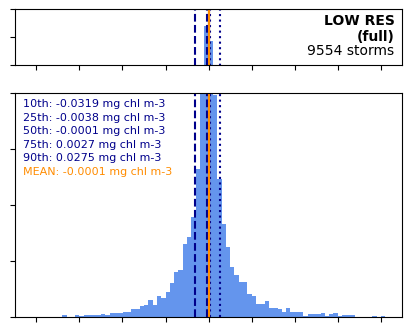

In [10]:
#----
# BROKEN Y AXIS
#----
from matplotlib.gridspec import GridSpec

bins = np.arange(-0.45,0.45+0.01,0.01)
color1 = 'cornflowerblue'
color2 = 'darkblue'
color3 = 'darkgrey'
color4 = 'darkorange'
ylim1 = 4000
fs = 8
factor = 10000

ww,hh = 5,4

print('low res, full...')

fig = plt.figure(figsize=(ww,hh))
gs = GridSpec(2, 2, height_ratios=[1, 4])

ax1 = fig.add_subplot(gs.new_subplotspec((0, 0), colspan=2))
ax2 = fig.add_subplot(gs.new_subplotspec((1, 0), colspan=2))

ax2.tick_params(axis="both", which="major", labelsize=10)
ax1.tick_params(axis="both", which="major", labelsize=10)
    
# LOWER PART
ax2.hist(ratio,bins,color=color1)
ax2.set_ylim((0,400))
ax2.vlines(0,0,ylim1,color=color3)
ax2.vlines(np.percentile(ratio[ind_no_NaN],10),0,ylim1,color=color2,linestyle='--')
ax2.vlines(np.percentile(ratio[ind_no_NaN],25),0,ylim1,color=color2,linestyle='--')
ax2.vlines(np.percentile(ratio[ind_no_NaN],50),0,ylim1,color=color2,linestyle='-')
ax2.vlines(np.percentile(ratio[ind_no_NaN],75),0,ylim1,color=color2,linestyle=':')
ax2.vlines(np.percentile(ratio[ind_no_NaN],90),0,ylim1,color=color2,linestyle=':')
ax2.vlines(np.mean(ratio[ind_no_NaN]),0,ylim1,color=color4,linestyle='-')
ax2.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
ax2.set_xticklabels([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
ax2.set_yticks([0,100,200,300,400])
ax2.set_yticklabels([0,100,200,300,400])
ax2.set_xlabel('Storm-induced chlorophyll anomalies in mg chl m$^{-3}$')
ax2.set_ylabel('Frequency')
ax2.set_xlim((np.min(bins),np.max(bins)))
ax2.annotate('10th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],10))/factor)+' mg chl m-3',\
             xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
ax2.annotate('25th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],25))/factor)+' mg chl m-3',\
             xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
ax2.annotate('50th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],50))/factor)+' mg chl m-3',\
             xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
ax2.annotate('75th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],75))/factor)+' mg chl m-3',\
             xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
ax2.annotate('90th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],90))/factor)+' mg chl m-3',\
             xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
ax2.annotate('MEAN: '+str(np.round(factor*np.mean(ratio[ind_no_NaN]))/factor)+' mg chl m-3',\
             xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')

# UPPER PART
ax1.hist(ratio,bins,color=color1)
ax1.set_ylim((2000,ylim1))
ax1.vlines(0,0,ylim1,color=color3)
ax1.vlines(np.percentile(ratio[ind_no_NaN],10),0,ylim1,color=color2,linestyle='--')
ax1.vlines(np.percentile(ratio[ind_no_NaN],25),0,ylim1,color=color2,linestyle='--')
ax1.vlines(np.percentile(ratio[ind_no_NaN],50),0,ylim1,color=color2,linestyle='-')
ax1.vlines(np.percentile(ratio[ind_no_NaN],75),0,ylim1,color=color2,linestyle=':')
ax1.vlines(np.percentile(ratio[ind_no_NaN],90),0,ylim1,color=color2,linestyle=':')
ax1.vlines(np.mean(ratio[ind_no_NaN]),0,ylim1,color=color4,linestyle='-')
ax1.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
ax1.set_xticklabels([])
ax1.set_yticks([2000,3000,4000])
ax1.set_yticklabels([2000,3000,4000])
ax1.set_xlim((np.min(bins),np.max(bins)))
ax1.annotate('LOW RES\n(full)',xy=(0.98,0.45),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
ax1.annotate(str(ind_no_NaN.shape[0])+' storms',xy=(0.98,0.2),xycoords='axes fraction',fontsize=fs+2,ha='right') 

if save_plots:
    filename = 'Histogram_all_storms_storm_anom_from_clim_LOW_RES_full_broken_y_axis.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
    
if plot_eps:
    
    fig = plt.figure(figsize=(ww,hh))
    gs = GridSpec(2, 2, height_ratios=[1, 4])

    ax1 = fig.add_subplot(gs.new_subplotspec((0, 0), colspan=2))
    ax2 = fig.add_subplot(gs.new_subplotspec((1, 0), colspan=2))

    ax2.tick_params(axis="both", which="major", labelsize=10)
    ax1.tick_params(axis="both", which="major", labelsize=10)

    # LOWER PART
    ax2.hist(ratio,bins,color=color1)
    ax2.set_ylim((0,400))
    ax2.vlines(0,0,ylim1,color=color3)
    ax2.vlines(np.percentile(ratio[ind_no_NaN],10),0,ylim1,color=color2,linestyle='--')
    ax2.vlines(np.percentile(ratio[ind_no_NaN],25),0,ylim1,color=color2,linestyle='--')
    ax2.vlines(np.percentile(ratio[ind_no_NaN],50),0,ylim1,color=color2,linestyle='-')
    ax2.vlines(np.percentile(ratio[ind_no_NaN],75),0,ylim1,color=color2,linestyle=':')
    ax2.vlines(np.percentile(ratio[ind_no_NaN],90),0,ylim1,color=color2,linestyle=':')
    ax2.vlines(np.mean(ratio[ind_no_NaN]),0,ylim1,color=color4,linestyle='-')
    ax2.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
    ax2.set_xticklabels([])
    ax2.set_yticks([0,100,200,300,400])
    ax2.set_yticklabels([])
    ax2.set_xlim((np.min(bins),np.max(bins)))
    ax2.annotate('10th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],10))/factor)+' mg chl m-3',\
                 xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('25th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],25))/factor)+' mg chl m-3',\
                 xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('50th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],50))/factor)+' mg chl m-3',\
                 xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('75th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],75))/factor)+' mg chl m-3',\
                 xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('90th: '+str(np.round(factor*np.percentile(ratio[ind_no_NaN],90))/factor)+' mg chl m-3',\
                 xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('MEAN: '+str(np.round(factor*np.mean(ratio[ind_no_NaN]))/factor)+' mg chl m-3',\
                 xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')

    # UPPER PART
    ax1.hist(ratio,bins,color=color1)
    ax1.set_ylim((2000,ylim1))
    ax1.vlines(0,0,ylim1,color=color3)
    ax1.vlines(np.percentile(ratio[ind_no_NaN],10),0,ylim1,color=color2,linestyle='--')
    ax1.vlines(np.percentile(ratio[ind_no_NaN],25),0,ylim1,color=color2,linestyle='--')
    ax1.vlines(np.percentile(ratio[ind_no_NaN],50),0,ylim1,color=color2,linestyle='-')
    ax1.vlines(np.percentile(ratio[ind_no_NaN],75),0,ylim1,color=color2,linestyle=':')
    ax1.vlines(np.percentile(ratio[ind_no_NaN],90),0,ylim1,color=color2,linestyle=':')
    ax1.vlines(np.mean(ratio[ind_no_NaN]),0,ylim1,color=color4,linestyle='-')
    ax1.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
    ax1.set_xticklabels([])
    ax1.set_yticks([2000,3000,4000])
    ax1.set_yticklabels([])
    ax1.set_xlim((np.min(bins),np.max(bins)))
    ax1.annotate('LOW RES\n(full)',xy=(0.98,0.45),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
    ax1.annotate(str(ind_no_NaN.shape[0])+' storms',xy=(0.98,0.2),xycoords='axes fraction',fontsize=fs+2,ha='right') 

    if save_plots:
        filename = 'Histogram_all_storms_storm_anom_from_clim_LOW_RES_full_broken_y_axis.eps'
        plt.savefig(savepath+'eps/'+filename[:-4]+'.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
    


low res, emulator...


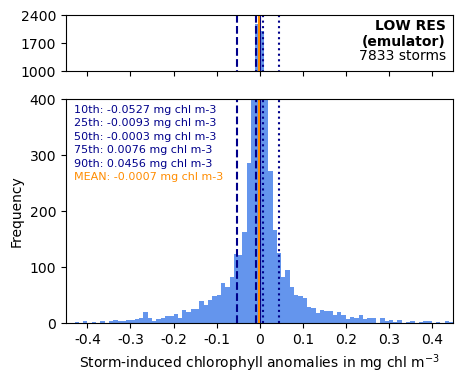

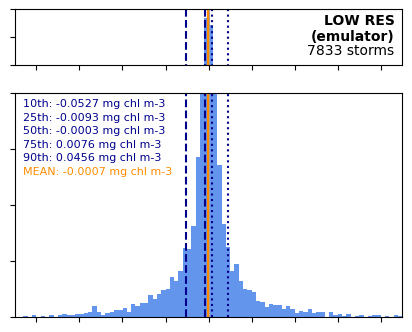

In [11]:

print('low res, emulator...')

fig = plt.figure(figsize=(ww,hh))
gs = GridSpec(2, 2, height_ratios=[1, 4])

ax1 = fig.add_subplot(gs.new_subplotspec((0, 0), colspan=2))
ax2 = fig.add_subplot(gs.new_subplotspec((1, 0), colspan=2))

ax2.tick_params(axis="both", which="major", labelsize=10)
ax1.tick_params(axis="both", which="major", labelsize=10)
    
# LOWER PART
ax2.hist(ratio_em,bins,color=color1)
ax2.set_ylim((0,400))
ax2.vlines(0,0,ylim1,color=color3)
ax2.vlines(np.percentile(ratio_em[ind_no_NaN_em],10),0,ylim1,color=color2,linestyle='--')
ax2.vlines(np.percentile(ratio_em[ind_no_NaN_em],25),0,ylim1,color=color2,linestyle='--')
ax2.vlines(np.percentile(ratio_em[ind_no_NaN_em],50),0,ylim1,color=color2,linestyle='-')
ax2.vlines(np.percentile(ratio_em[ind_no_NaN_em],75),0,ylim1,color=color2,linestyle=':')
ax2.vlines(np.percentile(ratio_em[ind_no_NaN_em],90),0,ylim1,color=color2,linestyle=':')
ax2.vlines(np.mean(ratio_em[ind_no_NaN_em]),0,ylim1,color=color4,linestyle='-')
ax2.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
ax2.set_xticklabels([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
ax2.set_yticks([0,100,200,300,400])
ax2.set_yticklabels([0,100,200,300,400])
ax2.set_xlabel('Storm-induced chlorophyll anomalies in mg chl m$^{-3}$')
ax2.set_ylabel('Frequency')
ax2.set_xlim((np.min(bins),np.max(bins)))
ax2.annotate('10th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],10))/factor)+' mg chl m-3',\
             xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
ax2.annotate('25th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],25))/factor)+' mg chl m-3',\
             xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
ax2.annotate('50th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],50))/factor)+' mg chl m-3',\
             xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
ax2.annotate('75th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],75))/factor)+' mg chl m-3',\
             xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
ax2.annotate('90th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],90))/factor)+' mg chl m-3',\
             xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
ax2.annotate('MEAN: '+str(np.round(factor*np.mean(ratio_em[ind_no_NaN_em]))/factor)+' mg chl m-3',\
             xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')

# UPPER PART
ax1.hist(ratio_em,bins,color=color1)
ax1.set_ylim((1000,2400))
ax1.vlines(0,0,ylim1,color=color3)
ax1.vlines(np.percentile(ratio_em[ind_no_NaN_em],10),0,ylim1,color=color2,linestyle='--')
ax1.vlines(np.percentile(ratio_em[ind_no_NaN_em],25),0,ylim1,color=color2,linestyle='--')
ax1.vlines(np.percentile(ratio_em[ind_no_NaN_em],50),0,ylim1,color=color2,linestyle='-')
ax1.vlines(np.percentile(ratio_em[ind_no_NaN_em],75),0,ylim1,color=color2,linestyle=':')
ax1.vlines(np.percentile(ratio_em[ind_no_NaN_em],90),0,ylim1,color=color2,linestyle=':')
ax1.vlines(np.mean(ratio_em[ind_no_NaN_em]),0,ylim1,color=color4,linestyle='-')
ax1.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
ax1.set_xticklabels([])
ax1.set_yticks([1000,1700,2400])
ax1.set_yticklabels([1000,1700,2400])
ax1.set_xlim((np.min(bins),np.max(bins)))
ax1.annotate('LOW RES\n(emulator)',xy=(0.98,0.45),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
ax1.annotate(str(ind_no_NaN_em.shape[0])+' storms',xy=(0.98,0.2),xycoords='axes fraction',fontsize=fs+2,ha='right') 

if save_plots:
    filename = 'Histogram_all_storms_storm_anom_from_clim_LOW_RES_emulator_broken_y_axis.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
    
if plot_eps:
    
    fig = plt.figure(figsize=(ww,hh))
    gs = GridSpec(2, 2, height_ratios=[1, 4])

    ax1 = fig.add_subplot(gs.new_subplotspec((0, 0), colspan=2))
    ax2 = fig.add_subplot(gs.new_subplotspec((1, 0), colspan=2))

    ax2.tick_params(axis="both", which="major", labelsize=10)
    ax1.tick_params(axis="both", which="major", labelsize=10)

    # LOWER PART
    ax2.hist(ratio_em,bins,color=color1)
    ax2.set_ylim((0,400))
    ax2.vlines(0,0,ylim1,color=color3)
    ax2.vlines(np.percentile(ratio_em[ind_no_NaN_em],10),0,ylim1,color=color2,linestyle='--')
    ax2.vlines(np.percentile(ratio_em[ind_no_NaN_em],25),0,ylim1,color=color2,linestyle='--')
    ax2.vlines(np.percentile(ratio_em[ind_no_NaN_em],50),0,ylim1,color=color2,linestyle='-')
    ax2.vlines(np.percentile(ratio_em[ind_no_NaN_em],75),0,ylim1,color=color2,linestyle=':')
    ax2.vlines(np.percentile(ratio_em[ind_no_NaN_em],90),0,ylim1,color=color2,linestyle=':')
    ax2.vlines(np.mean(ratio_em[ind_no_NaN_em]),0,ylim1,color=color4,linestyle='-')
    ax2.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
    ax2.set_xticklabels([])
    ax2.set_yticks([0,100,200,300,400])
    ax2.set_yticklabels([])
    ax2.set_xlim((np.min(bins),np.max(bins)))
    ax2.annotate('10th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],10))/factor)+' mg chl m-3',\
                 xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('25th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],25))/factor)+' mg chl m-3',\
                 xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('50th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],50))/factor)+' mg chl m-3',\
                 xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('75th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],75))/factor)+' mg chl m-3',\
                 xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('90th: '+str(np.round(factor*np.percentile(ratio_em[ind_no_NaN_em],90))/factor)+' mg chl m-3',\
                 xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('MEAN: '+str(np.round(factor*np.mean(ratio_em[ind_no_NaN_em]))/factor)+' mg chl m-3',\
                 xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')

    # UPPER PART
    ax1.hist(ratio_em,bins,color=color1)
    ax1.set_ylim((1000,2400))#,ylim1))
    ax1.vlines(0,0,ylim1,color=color3)
    ax1.vlines(np.percentile(ratio_em[ind_no_NaN_em],10),0,ylim1,color=color2,linestyle='--')
    ax1.vlines(np.percentile(ratio_em[ind_no_NaN_em],25),0,ylim1,color=color2,linestyle='--')
    ax1.vlines(np.percentile(ratio_em[ind_no_NaN_em],50),0,ylim1,color=color2,linestyle='-')
    ax1.vlines(np.percentile(ratio_em[ind_no_NaN_em],75),0,ylim1,color=color2,linestyle=':')
    ax1.vlines(np.percentile(ratio_em[ind_no_NaN_em],90),0,ylim1,color=color2,linestyle=':')
    ax1.vlines(np.mean(ratio_em[ind_no_NaN_em]),0,ylim1,color=color4,linestyle='-')
    ax1.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
    ax1.set_xticklabels([])
    ax1.set_yticks([1000,1700,2400])
    ax1.set_yticklabels([])
    ax1.set_xlim((np.min(bins),np.max(bins)))
    ax1.annotate('LOW RES\n(emulator)',xy=(0.98,0.45),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
    ax1.annotate(str(ind_no_NaN_em.shape[0])+' storms',xy=(0.98,0.2),xycoords='axes fraction',fontsize=fs+2,ha='right') 

    if save_plots:
        filename = 'Histogram_all_storms_storm_anom_from_clim_LOW_RES_emulator_broken_y_axis.eps'
        plt.savefig(savepath+'eps/'+filename[:-4]+'.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
    

    

high res, full...


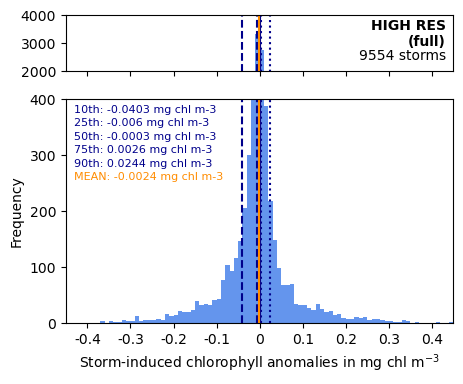

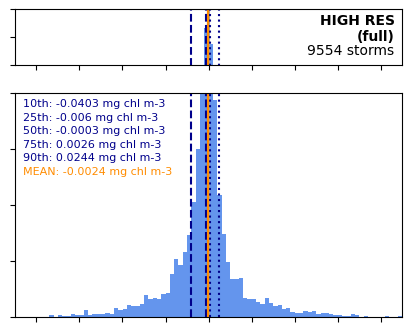

In [12]:

if plot_hr:
    print('high res, full...')

    fig = plt.figure(figsize=(ww,hh))
    gs = GridSpec(2, 2, height_ratios=[1, 4])

    ax1 = fig.add_subplot(gs.new_subplotspec((0, 0), colspan=2))
    ax2 = fig.add_subplot(gs.new_subplotspec((1, 0), colspan=2))

    ax2.tick_params(axis="both", which="major", labelsize=10)
    ax1.tick_params(axis="both", which="major", labelsize=10)

    # LOWER PART
    ax2.hist(ratio_hr,bins,color=color1)
    ax2.set_ylim((0,400))
    ax2.vlines(0,0,ylim1,color=color3)
    ax2.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],10),0,ylim1,color=color2,linestyle='--')
    ax2.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],25),0,ylim1,color=color2,linestyle='--')
    ax2.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],50),0,ylim1,color=color2,linestyle='-')
    ax2.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],75),0,ylim1,color=color2,linestyle=':')
    ax2.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],90),0,ylim1,color=color2,linestyle=':')
    ax2.vlines(np.mean(ratio_hr[ind_no_NaN_hr]),0,ylim1,color=color4,linestyle='-')
    ax2.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
    ax2.set_xticklabels([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
    ax2.set_yticks([0,100,200,300,400])
    ax2.set_yticklabels([0,100,200,300,400])
    ax2.set_xlabel('Storm-induced chlorophyll anomalies in mg chl m$^{-3}$')
    ax2.set_ylabel('Frequency')
    ax2.set_xlim((np.min(bins),np.max(bins)))
    ax2.annotate('10th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],10))/factor)+' mg chl m-3',\
                    xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('25th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],25))/factor)+' mg chl m-3',\
                    xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('50th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],50))/factor)+' mg chl m-3',\
                    xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('75th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],75))/factor)+' mg chl m-3',\
                    xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('90th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],90))/factor)+' mg chl m-3',\
                    xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
    ax2.annotate('MEAN: '+str(np.round(factor*np.mean(ratio_hr[ind_no_NaN_hr]))/factor)+' mg chl m-3',\
                    xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')

    # UPPER PART
    ax1.hist(ratio_hr,bins,color=color1)
    ax1.set_ylim((2000,ylim1))
    ax1.vlines(0,0,ylim1,color=color3)
    ax1.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],10),0,ylim1,color=color2,linestyle='--')
    ax1.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],25),0,ylim1,color=color2,linestyle='--')
    ax1.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],50),0,ylim1,color=color2,linestyle='-')
    ax1.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],75),0,ylim1,color=color2,linestyle=':')
    ax1.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],90),0,ylim1,color=color2,linestyle=':')
    ax1.vlines(np.mean(ratio_hr[ind_no_NaN_hr]),0,ylim1,color=color4,linestyle='-')
    ax1.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
    ax1.set_xticklabels([])
    ax1.set_yticks([2000,3000,4000])
    ax1.set_yticklabels([2000,3000,4000])
    ax1.set_xlim((np.min(bins),np.max(bins)))
    ax1.annotate('HIGH RES\n(full)',xy=(0.98,0.45),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
    ax1.annotate(str(ind_no_NaN_hr.shape[0])+' storms',xy=(0.98,0.2),xycoords='axes fraction',fontsize=fs+2,ha='right') 

    if save_plots:
        filename = 'Histogram_all_storms_storm_anom_from_clim_HIGH_RES_full_broken_y_axis.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)


    if plot_eps:

        fig = plt.figure(figsize=(ww,hh))
        gs = GridSpec(2, 2, height_ratios=[1, 4])

        ax1 = fig.add_subplot(gs.new_subplotspec((0, 0), colspan=2))
        ax2 = fig.add_subplot(gs.new_subplotspec((1, 0), colspan=2))

        ax2.tick_params(axis="both", which="major", labelsize=10)
        ax1.tick_params(axis="both", which="major", labelsize=10)

        # LOWER PART
        ax2.hist(ratio_hr,bins,color=color1)
        ax2.set_ylim((0,400))
        ax2.vlines(0,0,ylim1,color=color3)
        ax2.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],10),0,ylim1,color=color2,linestyle='--')
        ax2.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],25),0,ylim1,color=color2,linestyle='--')
        ax2.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],50),0,ylim1,color=color2,linestyle='-')
        ax2.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],75),0,ylim1,color=color2,linestyle=':')
        ax2.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],90),0,ylim1,color=color2,linestyle=':')
        ax2.vlines(np.mean(ratio_hr[ind_no_NaN_hr]),0,ylim1,color=color4,linestyle='-')
        ax2.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
        ax2.set_xticklabels([])
        ax2.set_yticks([0,100,200,300,400])
        ax2.set_yticklabels([])
        ax2.set_xlim((np.min(bins),np.max(bins)))
        ax2.annotate('10th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],10))/factor)+' mg chl m-3',\
                     xy=(0.02,0.94),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        ax2.annotate('25th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],25))/factor)+' mg chl m-3',\
                     xy=(0.02,0.88),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        ax2.annotate('50th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],50))/factor)+' mg chl m-3',\
                     xy=(0.02,0.82),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        ax2.annotate('75th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],75))/factor)+' mg chl m-3',\
                     xy=(0.02,0.76),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        ax2.annotate('90th: '+str(np.round(factor*np.percentile(ratio_hr[ind_no_NaN_hr],90))/factor)+' mg chl m-3',\
                     xy=(0.02,0.7),xycoords='axes fraction',color=color2,fontsize=fs,ha='left')
        ax2.annotate('MEAN: '+str(np.round(factor*np.mean(ratio_hr[ind_no_NaN_hr]))/factor)+' mg chl m-3',\
                     xy=(0.02,0.64),xycoords='axes fraction',color=color4,fontsize=fs,ha='left')

        # UPPER PART
        ax1.hist(ratio_hr,bins,color=color1)
        ax1.set_ylim((2000,ylim1))
        ax1.vlines(0,0,ylim1,color=color3)
        ax1.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],10),0,ylim1,color=color2,linestyle='--')
        ax1.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],25),0,ylim1,color=color2,linestyle='--')
        ax1.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],50),0,ylim1,color=color2,linestyle='-')
        ax1.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],75),0,ylim1,color=color2,linestyle=':')
        ax1.vlines(np.percentile(ratio_hr[ind_no_NaN_hr],90),0,ylim1,color=color2,linestyle=':')
        ax1.vlines(np.mean(ratio_hr[ind_no_NaN_hr]),0,ylim1,color=color4,linestyle='-')
        ax1.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
        ax1.set_xticklabels([])
        ax1.set_yticks([2000,3000,4000])
        ax1.set_yticklabels([])
        ax1.set_xlim((np.min(bins),np.max(bins)))
        ax1.annotate('HIGH RES\n(full)',xy=(0.98,0.45),xycoords='axes fraction',fontsize=fs+2,ha='right',fontweight='bold') 
        ax1.annotate(str(ind_no_NaN_hr.shape[0])+' storms',xy=(0.98,0.2),xycoords='axes fraction',fontsize=fs+2,ha='right') 

        if save_plots:
            filename = 'Histogram_all_storms_storm_anom_from_clim_HIGH_RES_full_broken_y_axis.eps'
            plt.savefig(savepath+'eps/'+filename[:-4]+'.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)

